In [2]:
# Use this if you want to mount the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from torch.nn import functional as F

In [0]:
#Original network
class SolarNet(Dataset):
    def __init__(self,i,l,r):
        self.images=i
        self.targets=l
        self.feats=r

    def __getitem__(self, index):
        item = {'image': self.images[index], 'power': self.targets[index], 'feats': self.feats[index]}
        return item
    
    def __len__(self):
        return self.images.shape[0]

class ImpactNet_A(nn.Module):
  def __init__(self):
    super().__init__()
    #Define dissembled operators
    self.dropout = nn.Dropout(p=0.5)
    self.relu=nn.ReLU()
    self.conv1=nn.Conv2d(3,16,7,padding=3)
    self.pool=nn.AvgPool2d(3)
    #AU1
    self.rcu1_conv=nn.Conv2d(16,32,1,2)
    self.rcu1=nn.Sequential(
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32)
        )
    #AU2
    self.rcu2_conv=nn.Conv2d(32,48,1,2)
    self.rcu2=nn.Sequential(
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48),
        nn.ReLU(),
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48)
        )
    #AU3
    self.rcu3_conv=nn.Conv2d(48,64,1,2)
    self.rcu3=nn.Sequential(
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64)
        )
    #AU4
    self.rcu4_conv=nn.Conv2d(64,80,1,2)
    self.rcu4=nn.Sequential(
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80)
        )
    #AU5
    self.rcu5_conv=nn.Conv2d(80,96,1,2)
    self.rcu5=nn.Sequential(
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96)
        )
    #FCs in Analysis unit part
    self.fu=nn.Linear(384,96)
    self.fc0=nn.Linear(96,96)

    #FC layers
    self.fc1=nn.Linear(4,64)
    self.fc2=nn.Linear(64,96)
    self.fc3=nn.Linear(192,32)
    self.fc4=nn.Linear(32,8)

  def forward(self,au,ef):
    #AU is output from images, EF is output from environment factors

    #Analysis network
    au=self.conv1(au)#1st layer: only conv2d
    au=self.relu(self.rcu1_conv(au)+self.rcu1(self.rcu1_conv(au)))#2nd layer: residual convolution unit
    au=self.relu(self.rcu2_conv(au)+self.rcu2(self.rcu2_conv(au)))#3rd layer: residual convolution unit
    au=self.relu(self.rcu3_conv(au)+self.rcu3(self.rcu3_conv(au)))#4th layer: residual convolution unit
    au=self.relu(self.rcu4_conv(au)+self.rcu4(self.rcu4_conv(au)))#5th layer: residual convolution unit
    au=self.relu(self.rcu5_conv(au)+self.rcu5(self.rcu5_conv(au)))#6th layer: residual convolution unit
    au=self.pool(au)#7th layer: maxpool 2d
    au=au.view(au.shape[0],-1)
    au=self.relu(self.dropout(self.fu(au)))
    au=self.relu(self.dropout(self.fc0(au)))

    #Fully Connect network
    ef=self.relu(self.dropout(self.fc1(ef)))
    ef=self.relu(self.dropout(self.fc2(ef)))
    
    o=torch.cat((ef,au),1)
    o=self.relu(self.dropout(self.fc3(o)))
    o=self.fc4(o)

    return o

In [0]:
#load data
def load_pic():
    """
    Load pictures
    Shape: (45754, 3, 192, 192)--(Batch size, Channel, Height, Width)
    """
    return np.load('drive/My Drive/nus/image.npy',mmap_mode='r')

def load_label():
    """
    Load power loss
    Shape: (45754,)--(Batch size)
    """
    return np.load('drive/My Drive/nus/label.npy',mmap_mode='r')

def load_feats():
    """
    Load environmental features
    Shape:(45754,4)--(Batch size,(Hour,Min,Sec,Irradiance level))
    """
    return np.load('drive/My Drive/nus/feats.npy',mmap_mode='r')

def load_all():
    """
    Load images, power loss and environmental features individually
    Return:
        images: Solar panel images
        Power_loss: %age power_loss of the panel with respect to the clean panel
        feats: environmental features
    """
    images=load_pic().transpose((0,3,1,2))
    Power_loss=load_label()
    feats=load_feats()
    return images,Power_loss,feats

def load_set():
    """
    Load the data as datasets
    Return:
        d_train: train set, includes 27537 data
        d_test: test set, includes 18217 data
    """
    i,l,r=load_all()
    print('Load all')
    indt=np.random.randint(45754,size=18217)
    indr=np.random.randint(45754,size=27537)
    print('begin random')
    d_train=SolarNet(i[indr],l[indr],r[indr])
    d_test=SolarNet(i[indt],l[indt],r[indt])
    return d_train,d_test

In [0]:
def error(net,test,etype='L1'):
  j=0
  loss=0
  for data in test:
    j+=1
    i,p,f=torch.FloatTensor(data['image']).view(-1,3,192,192).cuda(),torch.FloatTensor([data['power']]).cuda(),torch.FloatTensor(data['feats']).view(1,-1).cuda()
    out=net(i,f)
    _,out=torch.max(out.data,1)
    if etype=='L1':
      loss+=torch.abs((out*12.5+6.25)-p)
    elif etype=='MSE':
      loss+=((out*12.5+6.25)-p)**2
    elif etype=='BE':
      p=(p*100//12.5).long()
      if p!=out:
        loss+=1
  return loss/j

def qrloss(net,test):
  j=0
  loss=0
  for data in test:
    j+=1
    i,p,f=torch.FloatTensor(data['image']).view(-1,3,192,192).cuda(),torch.FloatTensor([data['power']]),torch.FloatTensor(data['feats']).view(1,-1).cuda()
    out=net(i,f).squeeze().cpu()
    qg=torch.sort(F.softmax(out,dim=0))[0]
    s=0
    for i in range(len(qg)):
      s+=qg[i]
      qg[i]=s
    qg=qg.unsqueeze(0)
    y_true=(torch.ones(8)*p)
    y_pred=torch.FloatTensor([12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0])
    e=(y_true-y_pred)
    temp=torch.cat((qg*e,(qg-1)*e))
    temp=torch.max(temp,dim=0)[0]
    loss+=torch.mean(temp)
  return loss/j
    

In [7]:
train,test=load_set()
train_dataloader=DataLoader(train, 32)

Load all
begin random


In [0]:
#Original network experiment
from tqdm import tqdm
import matplotlib.pyplot as plt

#train Resnet
epochs=30
lr=0.00001

belos=[]
mselos=[]
l1los=[]
qrlos=[]
net=ImpactNet_A()
net.cuda()
criteria=nn.CrossEntropyLoss()
for ii in tqdm(range(epochs)):
  if ii%10==0:
    sgd=torch.optim.SGD(net.parameters(),lr)
    lr=lr*0.1
  for j,data in enumerate(train_dataloader):
    i,p,f=data['image'].float().cuda(),data['power'],data['feats'].float().cuda()
    p=(p*100//12.5).long().cuda()
    sgd.zero_grad()
    out=net(i,f)
    loss=criteria(out,p)
    loss.backward()
    sgd.step()
  with torch.no_grad():
    a=qrloss(net,test)
    qrlos.append(a)
    print(a,loss)

  """
  #Experiment for report 1
  belos.append(error(net,test,etype='BE'))
  mselos.append(error(net,test,etype='MSE'))
  l1los.append(error(net,test,etype='L1'))
  """



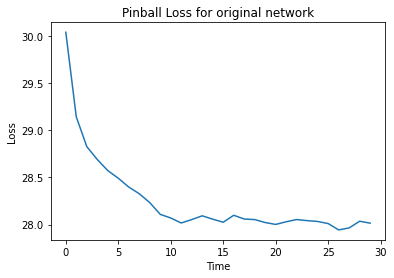

In [47]:
t=list(range(ii+1))

plt.figure()
plt.title('Pinball Loss for original network')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.plot(t,qrlos)

"""
#Experiment for report 1
plt.figure()
plt.title('Binary error')
plt.xlabel('Time')
plt.ylabel('Error %')
plt.plot(t,belos)

plt.figure()
plt.title('MSE loss')
plt.xlabel('Time')
plt.ylabel('Error %')
plt.plot(t,mselos)

plt.figure()
plt.title('L1 loss')
plt.xlabel('Time')
plt.ylabel('Error %')
plt.plot(t,l1los)
"""

plt.show()

In [0]:
#Modified network
def pin_ball_loss(y_true,y_pred):
  qg=(torch.FloatTensor(range(1,100))/100.0).unsqueeze(0).cuda()
  e=(y_true-y_pred).unsqueeze(0)
  temp=torch.cat((qg*e,(qg-1)*e))
  temp=torch.max(temp,dim=0)[0]
  loss=torch.mean(temp)
  return loss

def compute_test_loss(net,test):
  j=0
  loss=0
  for data in test:
    j+=1
    i,p,f=torch.FloatTensor(data['image']).view(-1,3,192,192).cuda(),torch.FloatTensor([data['power']]).cuda(),torch.FloatTensor(data['feats']).view(1,-1).cuda()
    out=net(i,f)
    loss+=pin_ball_loss(p,out)
  return loss/j

class NewNet(nn.Module):
  def __init__(self):
    super().__init__()
    #Define dissembled operators
    self.dropout = nn.Dropout(p=0.5)
    self.relu=nn.ReLU()
    self.conv1=nn.Conv2d(3,16,7,padding=3)
    self.pool=nn.AvgPool2d(3)
    #AU1
    self.rcu1_conv=nn.Conv2d(16,32,1,2)
    self.rcu1=nn.Sequential(
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32)
        )
    #AU2
    self.rcu2_conv=nn.Conv2d(32,48,1,2)
    self.rcu2=nn.Sequential(
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48),
        nn.ReLU(),
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48)
        )
    #AU3
    self.rcu3_conv=nn.Conv2d(48,64,1,2)
    self.rcu3=nn.Sequential(
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64)
        )
    #AU4
    self.rcu4_conv=nn.Conv2d(64,80,1,2)
    self.rcu4=nn.Sequential(
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80)
        )
    #AU5
    self.rcu5_conv=nn.Conv2d(80,96,1,2)
    self.rcu5=nn.Sequential(
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96)
        )
    #FCs
    self.fu=nn.Linear(384,96)
    self.fc0=nn.Linear(96,96)

    
    self.fc1=nn.Linear(4,64)
    self.fc2=nn.Linear(64,96)
    self.fc3=nn.Linear(192,32)
    self.fc4=nn.Linear(32,99)

  def forward(self,au,ef):
    #AU is output from images, EF is output from environment factors

    #Analysis network
    au=self.conv1(au)#1st layer: only conv2d
    au=self.relu(self.rcu1_conv(au)+self.rcu1(self.rcu1_conv(au)))#2nd layer: residual convolution unit
    au=self.relu(self.rcu2_conv(au)+self.rcu2(self.rcu2_conv(au)))#3rd layer: residual convolution unit
    au=self.relu(self.rcu3_conv(au)+self.rcu3(self.rcu3_conv(au)))#4th layer: residual convolution unit
    au=self.relu(self.rcu4_conv(au)+self.rcu4(self.rcu4_conv(au)))#5th layer: residual convolution unit
    au=self.relu(self.rcu5_conv(au)+self.rcu5(self.rcu5_conv(au)))#6th layer: residual convolution unit
    au=self.pool(au)#7th layer: maxpool 2d
    au=au.view(au.shape[0],-1)
    au=self.relu(self.dropout(self.fu(au)))
    au=self.relu(self.dropout(self.fc0(au)))

    #Fully Connect network
    ef=self.relu(self.dropout(self.fc1(ef)))
    ef=self.relu(self.dropout(self.fc2(ef)))
    
    o=torch.cat((ef,au),1)
    o=self.relu(self.dropout(self.fc3(o)))
    o=self.fc4(o)

    return o

In [0]:
#modified network experiment
from tqdm import tqdm
import matplotlib.pyplot as plt

#train Resnet
epochs=30
lr=0.00001

pinball_loss=[]
net=NewNet()
net.cuda()
for ii in tqdm(range(epochs)):
  if ii%10==0:
    sgd=torch.optim.SGD(net.parameters(),lr)
    lr=lr*0.1
  net.train()
  for j,data in (enumerate(train_dataloader)):
    i,p,f=data['image'].float().cuda(),data['power'].float().cuda(),data['feats'].float().cuda()
    p=p.view(-1,1)
    pnew=torch.ones((p.shape[0],99),dtype=float).cuda()
    p=p*pnew*100
    sgd.zero_grad()
    out=net(i,f)
    loss=pin_ball_loss(p,out)
    loss.backward()
    sgd.step()
  net.eval()
  with torch.no_grad():
    a=compute_test_loss(net,test)
    pinball_loss.append(float(a))
    print(a,loss)
    

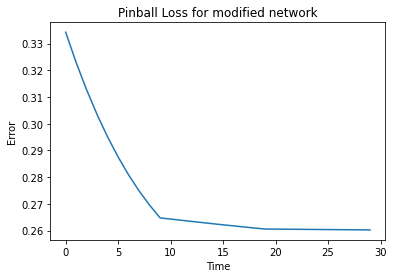

In [48]:
t=list(range(ii+1))
plt.figure()
plt.title('Pinball Loss for modified network')
plt.xlabel('Time')
plt.ylabel('Error')
plt.plot(t,pinball_loss)

plt.show()